# Architectural Optimizations

## Overview

We discuss here 3 different approaches to speed up finetuning . Note - These are architectural changes 

LoRA, adapters, prefix tuning

The goal is simply this - large LLMs have parameteters in the 100M - 1T range. For pretraining, we have to pretrain the whole network. For task specific finetuning, traditionally, the whole network is finetuned on a smaller data set. This is very expensive, especially if the parameter size goes in the B range

So can we in say finetune only a subset of weights during finetuning instead of the whole network, instead of all the weights ?

All the 3 approaches above have different ways of doing this

## Adapter layers

In this technique, we add two adapter modules for every layer in the transformer - once just after the self-attention block, after the multiheaded self-attention is projected; and second after the 2 feed forward blocks in the compute block. The adapter is always applied directly to the output of the sub-layer, after the projection back to the input size, but before adding the skip connection back. The output of adapter is passed to layer normalization

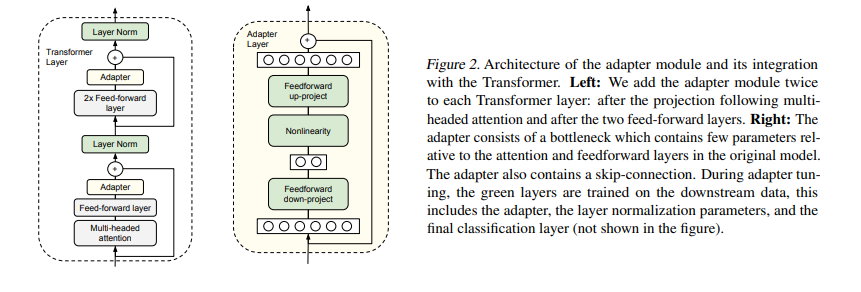

During finetuning, only these adapter layer weights are allowed to adapt, the rest of the weights remain frozen

Since the no of parameters in the adapter layers is much lesser than the no of parameters of the whole network, finetuning becomes a lot more efficient.

The adapters first project the original d-dimensional features into a smaller dimension, m, apply a nonlinearity, then project back to d dimensions. m<<d. The total no of new parameters is thus 2md + m + d. In practice, around 0.5-8% of the number of parameters of the original model is used. The adapter module itself has a skip-connection internally. With the skip-connection, if the parameters of the projection layers are initialized to near-zero, the module is initialized to an approximate identity function

Adapter finetuning attains a performance comparable to full network finetuning, with two orders of magnitude fewer parameters !!

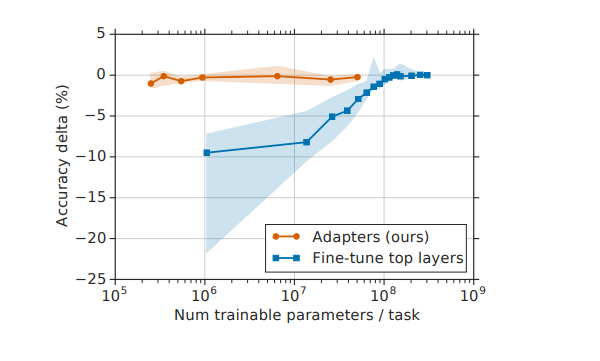

### Advantages

1) With only a 0.5-8% additional parameters during finetuning, and adapting only the additional adapter modules, we get comparable performnace to full finetuning - This means faster finetuning speeds, lesser data need


### Disadvantages

The adapter bottleneck layer doesn't align well with techniques like pipeline parallelism which are necessary these days to finetune Billion model  LLMs4
In an online inference setting where the batch size is typically as small as on, In a
generic scenario without model parallelism, such as running inference on GPT-2 (Radford et al., b) medium on a single GPU, we see a noticeable increase in latency when using adapters, even with a very small bottleneck dimension (Table 1)



This problem gets worse when we need to shard the model  because the additional depth requires more synchronous GPU operations such as AllReduce and Broadcast, unless we store the adapter parameters redundantly many time

## References

1) https://arxiv.org/pdf/2106.09685.pdf - LoRA paper
2) https://arxiv.org/abs/2101.00190 - prefix tuning paper
3) https://arxiv.org/pdf/1902.00751.pdf adapter networks